In [1]:
import SimpleITK as sitk
import numpy as np


In [2]:
def generate_sequence(width, height, num_frames, radius, amplitude, frequency, dtype=np.float32):
    # This function generates an example of an 2d+t image sequence
    # by strategically morphing a single image.
    #       -       -       -       -
    # o---/   \   /   \   /   \   /   
    #           -       -       -   

    # Create a grid of coordinates
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    xx, yy = np.meshgrid(x, y)
    grid = np.stack([xx, yy])

    # Create a sequence of frames
    sequence = np.zeros((num_frames, height, width), dtype=dtype)
    path = np.zeros((num_frames, 2), dtype=np.float32)
    for t in range(num_frames):
        # Compute the position of the circle
        center_x = 0
        center_y = amplitude * np.sin(2 * np.pi * frequency * t / num_frames)
        center = np.array([center_x, center_y])
        path[t] = center
        # Compute the distance to the circle
        distance = np.linalg.norm(grid - center[:, None, None], axis=0)

        # Create the frame
        frame = (distance < radius).astype(dtype)
        sequence[t] = frame

    return sequence, path

In [3]:
S, _path = generate_sequence(width=125,
                            height=125,
                            num_frames=10,
                            radius=0.5,
                            amplitude=0.4,
                            frequency=2)

# To (H, W, T) such that simpleitk maps to (T, H, W) again
S = S.transpose(1, 2, 0)

labels = (S > 0).astype(np.uint8)

frames = S.astype(np.float32)
noise = np.abs(np.random.normal(0, 0.5, S.shape)) # normal noise
frames += noise
frames = np.clip(frames, 0, 1)
frames *= 255
frames = frames.astype(np.uint16)

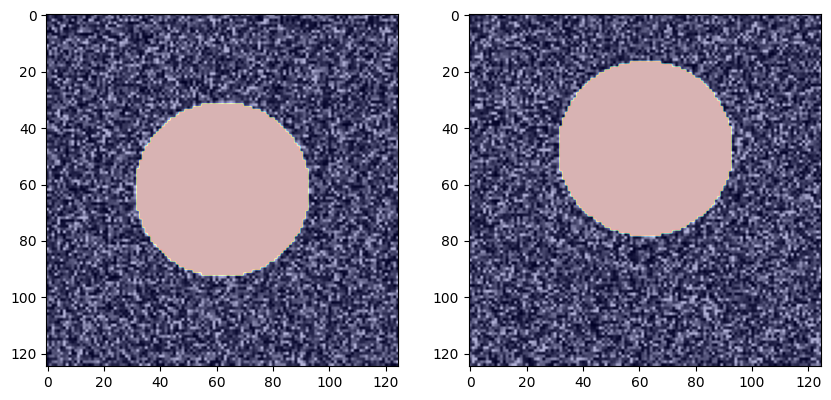

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(frames[:,:,0], cmap='gray')
ax[0].imshow(labels[:,:,0], cmap='jet', alpha=0.3)
ax[1].imshow(frames[:,:,3], cmap='gray')
ax[1].imshow(labels[:,:,3], cmap='jet', alpha=0.3)


In [5]:
!mkdir -p -m 777 ../dataset/example/Z_001
!mkdir -p -m 777 ../dataset/example/Z_001/images
!mkdir -p -m 777 ../dataset/example/Z_001/targets
!echo "0.35" > ../dataset/example/Z_001/b-field-strength.json
!echo "8.0" > ../dataset/example/Z_001/frame-rate.json
!echo '"abdomen"' > ../dataset/example/Z_001/scanned-region.json

In [6]:
# Create the images/${case_id}_frames.mha
simple_itk_image = sitk.GetImageFromArray(S)

# set metadata to something sensible
simple_itk_image.SetSpacing([5.0, 1.0,1.0]) # z=5mm, x=1mm, y=1mm slice spacing
simple_itk_image.SetOrigin([0.1053, 0.4946, 38.5])

print(simple_itk_image.GetSize())
print(simple_itk_image.GetSpacing())
print(simple_itk_image.GetOrigin())
print(simple_itk_image.GetPixelIDTypeAsString())

sitk.WriteImage(simple_itk_image, '../dataset/example/Z_001/images/Z_001_frames.mha',
                useCompression=True)


(10, 125, 125)
(5.0, 1.0, 1.0)
(0.1053, 0.4946, 38.5)
32-bit float


In [7]:
# Create the targets/${case_id}_labels.mha
simple_itk_image = sitk.GetImageFromArray(labels)

# set metadata to something sensible
simple_itk_image.SetSpacing([5.0, 1.0,1.0]) # z=5mm, x=1mm, y=1mm slice spacing
simple_itk_image.SetOrigin([0.1053, 0.4946, 38.5])

print(simple_itk_image.GetPixelIDTypeAsString())

sitk.WriteImage(simple_itk_image, '../dataset/example/Z_001/targets/Z_001_labels.mha', useCompression=True)


8-bit unsigned integer


In [8]:
# Create the targets/${case_id}_labels.mha
simple_itk_image = sitk.GetImageFromArray(labels[:, :, 0:1])

# set metadata to something sensible
simple_itk_image.SetSpacing([5.0, 1.0,1.0]) # z=5mm, x=1mm, y=1mm slice spacing
simple_itk_image.SetOrigin([0.1053, 0.4946, 38.5])

sitk.WriteImage(simple_itk_image, '../dataset/example/Z_001/targets/Z_001_first_label.mha', useCompression=True)